In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import multitest as multi
from matplotlib import pyplot as plt
import seaborn as sns
import snapfish2
snapfish2.MulFish.default_cols.extend(["Replicate", "FOV"])

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
path = "../../data/takei_science_2021/{}.csv"
id4dn = pd.DataFrame([
    ["4DNFI4JGAIHP", "4DNFIKS7TMJI", "4DNFIAMHROQM"],
    ["4DNFIW4S8M6J", "4DNFI4LI6NNV", "4DNFIDUJQDNO"],
    ["4DNFIG1KETHF", "4DNFIFEOFBK4", "4DNFI6C764XE"]
], columns=["rep1", "rep2", "rep3"])
id4dn.index = ["1Mb", "25kb", "Type"]

In [46]:
dfs = []
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro', 
                 6:'Micro', 7:'Endo',  8:'Oligo', 9:'Ex'}
for c in id4dn.columns:
    m = snapfish2.MulFish(path.format(id4dn["rep1"]["25kb"]))
    m.data.Trace_ID = c + "_" + m.data.Trace_ID
    cty = snapfish2.MulFish(path.format(id4dn["rep1"]["Type"]))
    m.data["X"] *= 103
    m.data["Y"] *= 103
    m.data["Z"] *= 250
    cty.data["label"] = cty.data["cluster label"].map(celltype_dict)
    cty_df = cty.data[["Cell_ID", "label"]]
    df = pd.merge(m.data, right=cty_df, how="left", on="Cell_ID")
    dfs.append(df)
df = pd.concat(dfs)
mfr = snapfish2.MulFish(df[df["label"]!="9"].copy())
del df, dfs

In [72]:
from collections import Counter
ct = Counter(mfr["chr3"][["Trace_ID", "label"]].drop_duplicates()["label"])
ct

Counter({'Ex': 2349,
         'Astro': 249,
         'Endo': 231,
         'Pvalb': 165,
         'Oligo': 102,
         'Micro': 93,
         'Sst': 72,
         'Vip': 66,
         'Ndnf': 60})

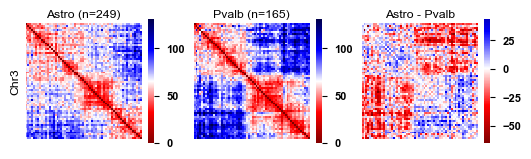

In [75]:
chr_id, c1, c2, s = "chr3", "Astro", "Pvalb", 10e3
data1 = mfr[("Chrom", chr_id), ("label", c1)]
data2 = mfr[("Chrom", chr_id), ("label", c2)]

arr1 = snapfish2.utils.to_very_wide(data1)[1]
avg_dist1 = np.nanmean(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)
arr2 = snapfish2.utils.to_very_wide(data2)[1]
avg_dist2 = np.nanmean(np.sqrt(np.sum(np.square(arr2), axis=1)), axis=0)

dist_diff = avg_dist1 - avg_dist2

fig, axes = plt.subplots(1, 3, figsize=(5.2,1.5))
snapfish2.plot.pairwise_heatmap(avg_dist1, ax=axes[0], x=f"{c1} (n={ct[c1]})", y=chr_id.title())
a, b = axes[0].collections[0].get_clim()
snapfish2.plot.pairwise_heatmap(avg_dist2, ax=axes[1], vmin=a, vmax=b, x=f"{c2} (n={ct[c2]})")
snapfish2.plot.pairwise_heatmap(dist_diff, ax=axes[2], center=0, x=f"{c1} - {c2}")

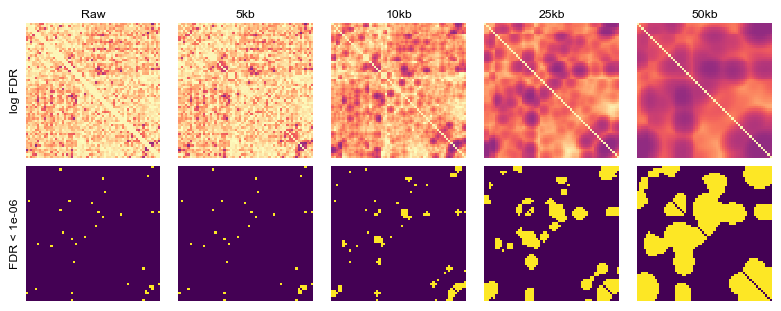

In [63]:
ss, cut = [1, 5e3, 10e3, 25e3, 50e3], 1e-6
fig, axes = plt.subplots(2, len(ss), figsize=(len(ss)*1.55, 3))
import warnings
warnings.filterwarnings("ignore", "invalid value encountered in divide")
for s, ax1, ax2 in zip(ss, axes[0], axes[1]):
    dre = snapfish2.loop.diff.DiffRegion(data1, data2, s=s)
    results = dre.diff_from_single_reg(chr_id)
    (x, y, c) = (f"{int(s/1e3)}kb", "", "") if s != 1 else ("Raw", "log FDR", f"FDR < {cut:.0e}")
    snapfish2.plot.pairwise_heatmap(np.log(results["fdr"]), ax=ax1, x=x, y=y,
                                    vmin=-30, vmax=0, cbar=False, cmap="magma")
    snapfish2.plot.pairwise_heatmap(results["fdr"] < cut, ax=ax2, y=c, cbar=False, cmap="viridis")